In [3]:
! snakemake --dag "output/embedding/umap/{model}.parquet" | dot -Tsvg > umap_flow.svg

/bin/bash: line 1: dot: command not found
/home/sbuedenb/gpn/analysis/arabidopsis/Snakefile:189: SyntaxWarning: invalid escape sequence '\_'
  "input/repeats.bed.gz",
/home/sbuedenb/gpn/analysis/arabidopsis/Snakefile:190: SyntaxWarning: invalid escape sequence '\_'
  output:
Wildcard constraints in inputs are ignored. (rule: process_conservation)
Building DAG of jobs...
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


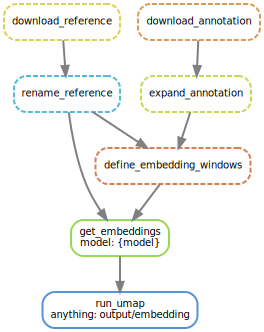

In [4]:
from IPython.core.display import SVG
SVG(filename='umap_flow.svg')

In [3]:
!pip install --upgrade \
  umap-learn \
  pandas \
  dask[complete] \
  datashader \
  holoviews \
  bokeh


Defaulting to user installation because normal site-packages is not writeable
  Using cached holoviews-1.20.2-py3-none-any.whl.metadata (9.9 kB)
  Using cached bokeh-3.6.3-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 201.9 MB/s eta 0:00:00
Using cached holoviews-1.20.2-py3-none-any.whl (5.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 95.6 MB/s eta 0:00:00
Using cached bokeh-3.6.3-py3-none-any.whl (6.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 143.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 100.0 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2023.1.0
    Uninstalling dask-2023.1.0:
      Successfully uninstalled dask-2023.1.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script

In [1]:
import bioframe as bf
import gpn.model
from gpn.data import load_table, Genome
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import umap
import umap.plot

/opt/conda/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/conda/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/conda/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)


In [8]:
gtf = load_table("resources/Lan3.1.genomic.gff3.gz")

In [10]:
gtf.feature.unique()

array(['exon', 'gene', 'transcript', 'intron', 'stop_codon', 'CDS',
       'start_codon'], dtype=object)

In [2]:
MODEL = "gonzalobenegas/gpn-brassicales"
#MODEL = "kmers_5"

d = Path("results/embedding")
#d = Path("output/embedding/subset_no_repeats")

windows = pd.read_parquet(d / "windows.parquet")
windows.loc[:, ["UMAP1", "UMAP2"]] = pd.read_parquet(d / "umap" / f"{MODEL}.parquet").values
windows

,chrom,start,end,strand,center_start,center_end,Region,UMAP1,UMAP2
0,chr1,0,512,+,206,306,intergenic,2.600413,7.692306
1,chr1,100,612,+,306,406,intergenic,3.895167,7.212097
2,chr1,200,712,+,406,506,intergenic,11.245571,16.588976
3,chr1,300,812,+,506,606,intergenic,10.457035,16.869461
4,chr1,400,912,+,606,706,intergenic,0.486396,8.930129
...,...,...,...,...,...,...,...,...,...
1416680,chr8,20382986,20383498,+,20383192,20383292,intergenic,1.508984,12.922990
1416681,chr8,20383086,20383598,+,20383292,20383392,intergenic,0.663925,11.653975
1416682,chr8,20383186,20383698,+,20383392,20383492,intergenic,-0.127895,9.421673
1416683,chr8,20383386,20383898,+,20383592,20383692,CDS,-1.296965,7.795913


In [3]:
windows.Region = windows.Region.replace({
    "intergenic": "Intergenic",
    "intron": "Intron",
    "ncRNA_gene": "ncRNA",
    "five_prime_UTR": "5' UTR",
    "three_prime_UTR": "3' UTR",
})

In [4]:
mapper = umap.UMAP()
mapper.embedding_ = windows[["UMAP1", "UMAP2"]].values

In [5]:
def get_color_key(classes, palette):
    color_palette = sns.color_palette(palette, n_colors=len(classes)).as_hex()
    return {c: color_palette[i] for i, c in enumerate(classes)}

# classes = [
#     "Intergenic",
#     "CDS",
#     "Intron",
#     "3' UTR",
#     "5' UTR",
#     "ncRNA",
#     "Repeat"
# ]

# def get_color_key(classes, palette):
#     color_palette = sns.color_palette(palette, n_colors=len(classes)).as_hex()
#     return {c: color_palette[i] for i, c in enumerate(classes)}

def umap_plot_labels(labels, title, show_labels, label_order, cmap="tab10", save_to=None, **kwargs):
    g = umap.plot.points(
        mapper,
        labels=labels,
        subset_points=labels.isin(show_labels),
        color_key=get_color_key(label_order, cmap),
        **kwargs,
    );
    sns.move_legend(g, "lower right")
    #sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));
    g.legend_.set_title(title);
    sns.despine();
    for txt in g.texts:
        txt.set_visible(False)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    if save_to is not None:
        plt.savefig(save_to, bbox_inches="tight")

In [6]:
# default is 100
plt.rcParams["figure.dpi"] = 100 #200  # need to play with both this and height,width
plt.rcParams['font.size'] = 20

In [7]:
# avoid having both green and red
color_palette = np.array(sns.color_palette("tab10"))[[0,1,9,3,4,5,6]]

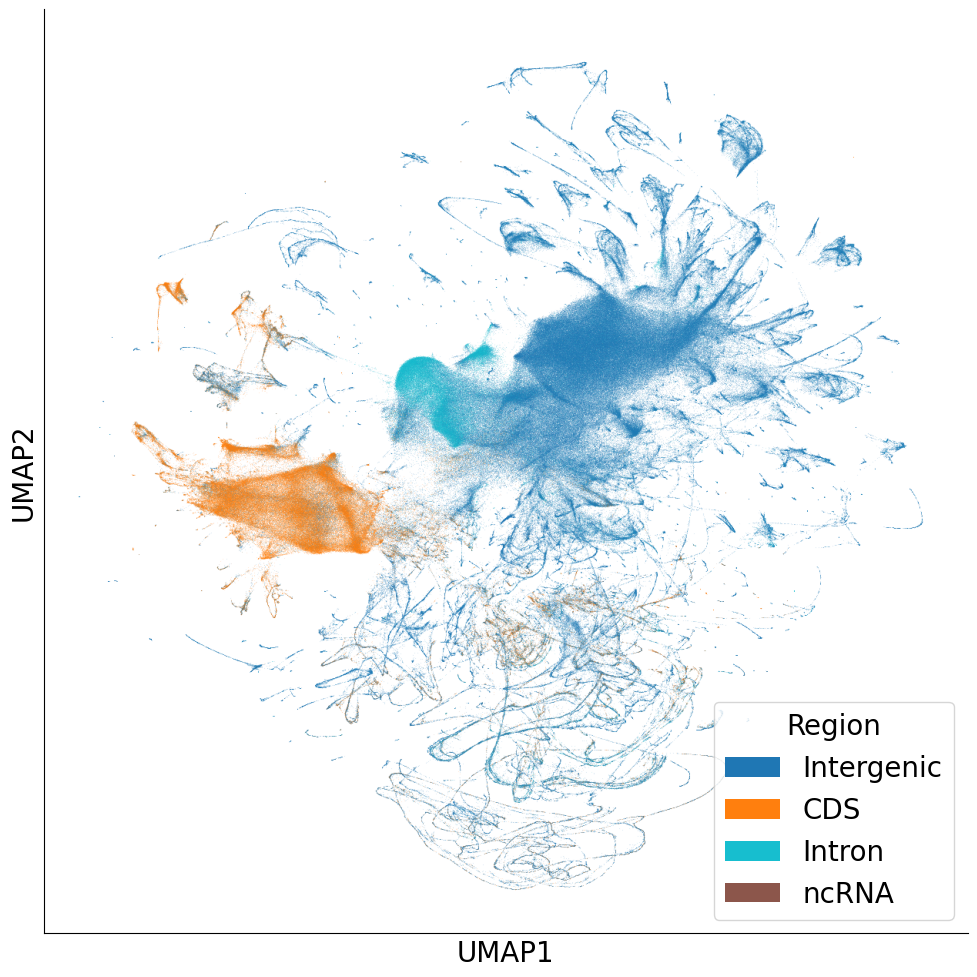

In [12]:
color_palette = np.array(sns.color_palette("tab10"))[[
    0,
    1,
    9,
    # 3,
    # 4,
    5,
    # 6
]]

show_regions = [
    "Intergenic",
    "CDS",
    "Intron",
    # "3' UTR",
    # "5' UTR",
    "ncRNA",
    # "Repeat"
]

classes = [
    "Intergenic",
    "CDS",
    "Intron",
    # "3' UTR",
    # "5' UTR",
    "ncRNA",
    # "Repeat"
]
    
umap_plot_labels(
    windows.Region, "Region", show_regions, classes, cmap=color_palette,
    height=1200, width=1200,
    save_to=f"results/plots/umap_{MODEL.replace('/', '_')}.png",
    # save_to=f"output/plots/umap_no_intergenic_{MODEL.replace('/', '_')}.svg",
)

In [40]:
windows.Region.value_counts()

Region
Intergenic    982617
CDS           248550
Intron        174515
ncRNA          11003
Name: count, dtype: int64

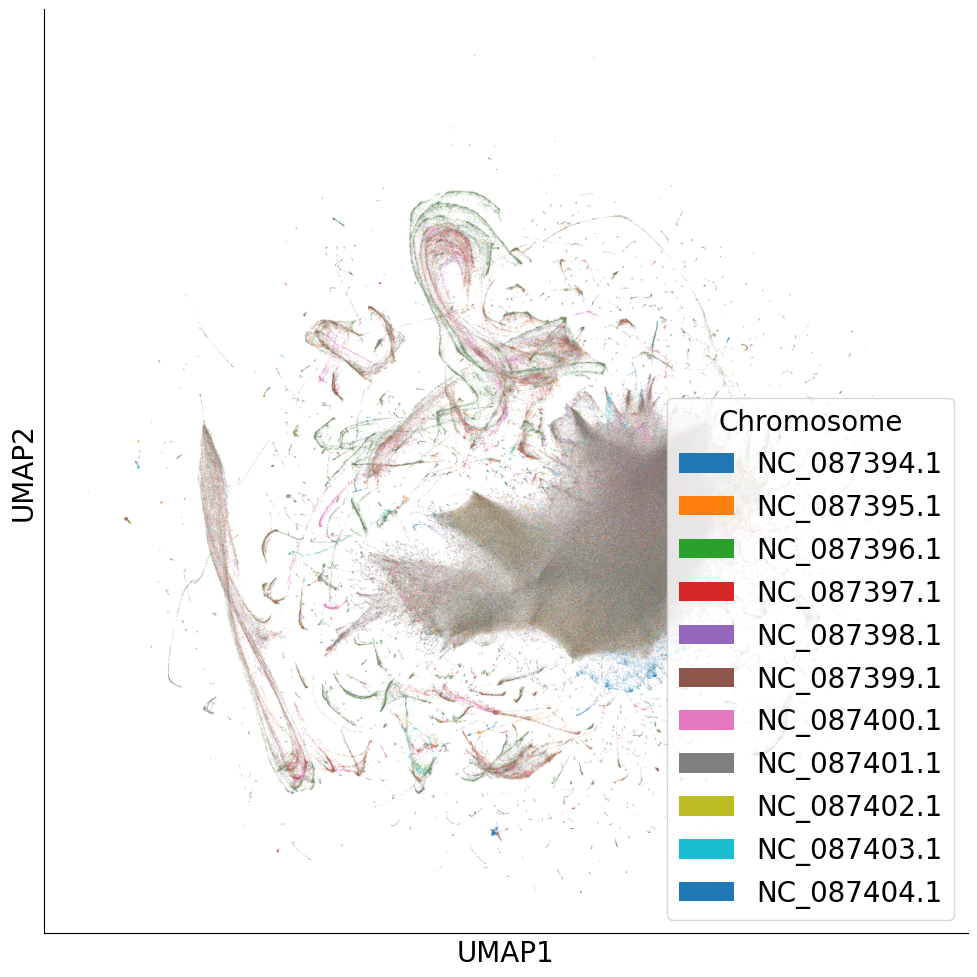

In [49]:
umap_plot_labels(windows.chrom, "Chromosome", windows.chrom.unique(), height=1200, width=1200)

In [49]:
repeats = pd.read_csv("input/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats.chrom = repeats.chrom.str.replace("Chr", "")
repeats

,#bin,swScore,milliDiv,milliDel,milliIns,chrom,start,end,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
0,10,444,191,54,76,1,12582773,12582920,-17844751,-,Helitron1,RC,Helitron,-9953,5856,5713,5
1,10,6899,30,0,1,1,13630758,13631561,-16796110,-,ATENSPM2,DNA,CMC-EnSpm,-6268,1985,1184,6
2,10,2521,72,3,2,1,14676131,14685672,-15741999,-,AR3,Satellite,Satellite,-73,9553,1,6
3,10,6227,45,48,6,1,15728234,15729041,-14698630,+,ATCopia95LTR,LTR,Copia,1,841,0,8
4,11,537,291,44,131,1,18873944,18874466,-11553205,-,Atlantys3_LTR,LTR,Gypsy,-12,482,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69340,587,238,156,0,0,M,361356,361401,-5523,-,SSU-rRNA_Ath,rRNA,rRNA,-16,1886,1842,6
69341,587,278,263,0,0,M,361523,361599,-5325,-,SSU-rRNA_Ath,rRNA,rRNA,-164,1738,1663,6
69342,587,582,289,31,44,M,362179,362407,-4517,-,SSU-rRNA_Ath,rRNA,rRNA,-481,1421,1197,6
69343,587,336,258,62,42,M,364854,365016,-1908,+,LSU-rRNA_Ath,rRNA,rRNA,797,961,-2414,6


In [50]:
top_repClass = repeats.repClass.value_counts().head(7).index.values
print(top_repClass)
repeats.repClass.value_counts()

['Simple_repeat' 'Low_complexity' 'DNA' 'LTR' 'RC' 'LINE' 'Satellite']


Simple_repeat     35153
Low_complexity     8892
DNA                8585
LTR                8576
RC                 3882
LINE               1785
Satellite          1347
SINE                616
Other               165
DNA?                112
RC?                  93
LINE?                74
rRNA                 48
SINE?                17
Name: repClass, dtype: int64

In [51]:
repeats.repFamily.value_counts()

Simple_repeat     35153
Low_complexity     8892
Gypsy              5580
MULE-MuDR          3942
Helitron           3882
Copia              2271
L1                 1785
DNA                1281
CMC-EnSpm           853
hAT-Ac              765
centr               752
Cassandra           725
Satellite           595
TcMar-Pogo          468
PIF-Harbinger       420
hAT                 386
TcMar-Stowaway      337
tRNA                334
SINE                282
Composite           161
DNA?                112
hAT-Tag1             99
Helitron?            93
LINE?                74
rRNA                 48
TcMar-Mariner        34
SINE?                17
centromeric           4
Name: repFamily, dtype: int64

In [52]:
repeats.repName.value_counts()

A-rich       5966
(T)n         2878
GA-rich      2864
(A)n         2192
(AT)n        2166
             ... 
(TGCTTG)n       1
(AAAGTG)n       1
(CTCCAA)n       1
(AGCTAG)n       1
(TGACT)n        1
Name: repName, Length: 4194, dtype: int64

In [53]:
# if a window overlaps multiple repeats we just take the first one
windows = bf.overlap(windows, repeats, how="left").drop_duplicates(["chrom", "center_start"])
windows

,chrom,start,end,strand,center_start,center_end,Region,UMAP1,UMAP2,#bin_,...,end_,genoLeft_,strand_,repName_,repClass_,repFamily_,repStart_,repEnd_,repLeft_,id_
0,1,0,512,+,206.0,306.0,Intergenic,-0.028450,6.717154,585.0,...,107,-30427564.0,-,ATREP18,DNA,DNA,-1142.0,649.0,561.0,1.0
1,1,100,612,+,306.0,406.0,Intergenic,-0.238723,6.999189,585.0,...,107,-30427564.0,-,ATREP18,DNA,DNA,-1142.0,649.0,561.0,1.0
2,1,200,712,+,406.0,506.0,Intergenic,-0.622261,6.540700,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
3,1,300,812,+,506.0,606.0,Intergenic,-0.317216,7.171642,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
4,1,400,912,+,606.0,706.0,Intergenic,-0.569555,6.597675,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897457,5,26974534,26975046,+,26974740.0,26974840.0,Intergenic,0.268297,6.255438,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
897458,5,26974634,26975146,+,26974840.0,26974940.0,Intergenic,-1.554088,2.486017,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
897459,5,26974734,26975246,+,26974940.0,26975040.0,Intergenic,-0.515367,2.835551,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
897460,5,26974834,26975346,+,26975040.0,26975140.0,Intergenic,-0.267551,3.624983,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN


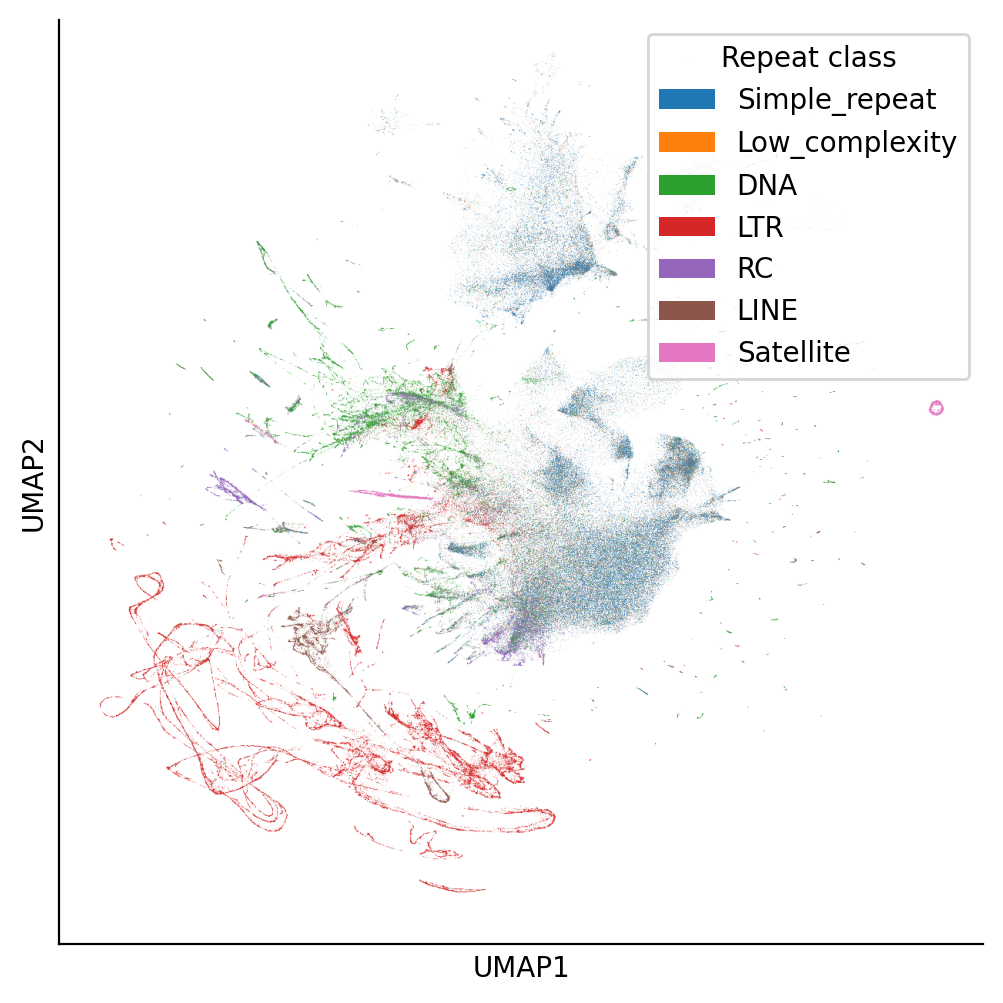

In [54]:
umap_plot_labels(windows.repClass_, "Repeat class", top_repClass, height=1200, width=1200)

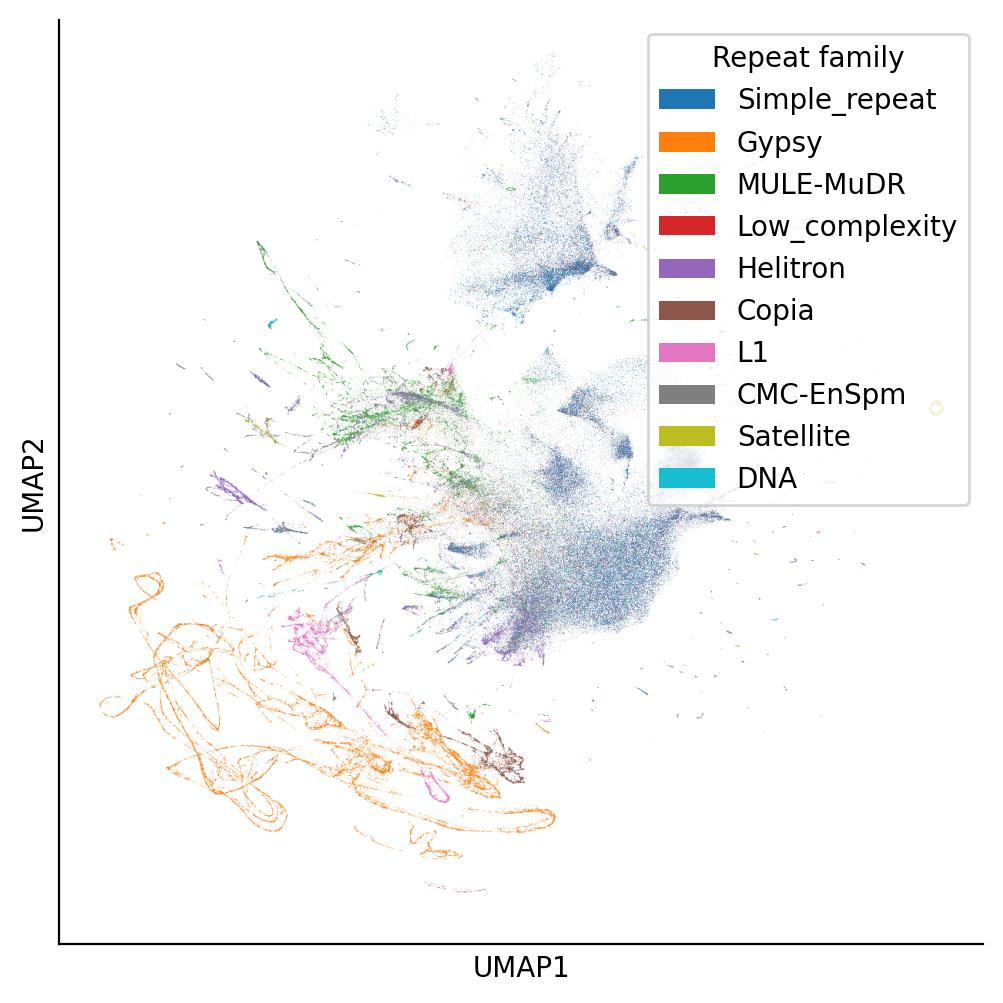

In [55]:
# maybe use a different color palette
umap_plot_labels(windows.repFamily_, "Repeat family", windows.repFamily_.value_counts().head(10).index.values, height=1200, width=1200, save_to="output/plots/umap_repeat_family.pdf")

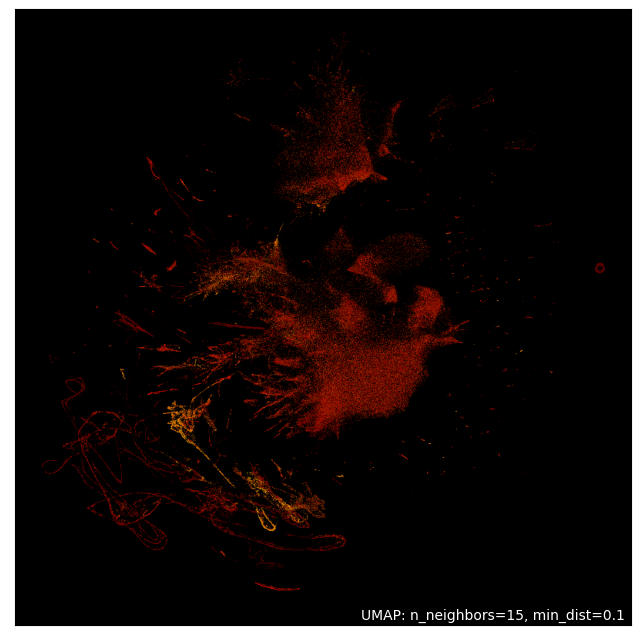

In [16]:
# no idea how to plot colorbar yet
# could just do it in seaborn extracting mapper.embedding
# or with datashader
labels = windows.milliDiv_
g = umap.plot.points(
    mapper,
    values=labels,
    subset_points=~labels.isna(),
    theme="fire",
);

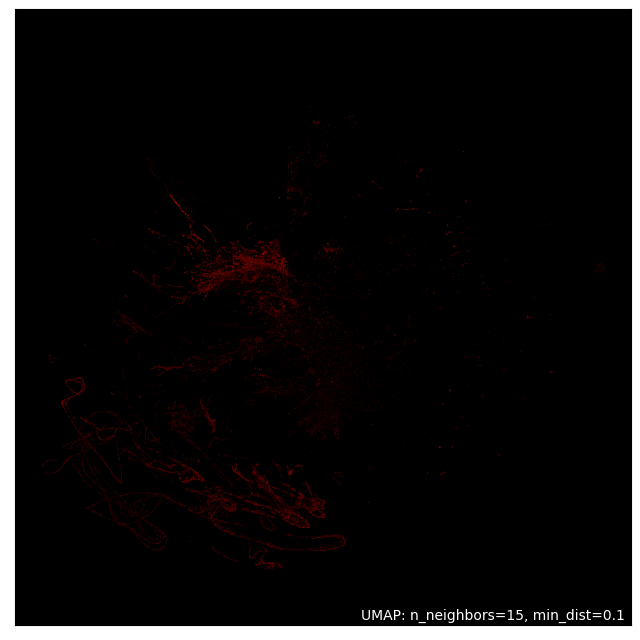

In [17]:
labels = windows.swScore_
g = umap.plot.points(
    mapper,
    values=labels,
    subset_points=~labels.isna(),
    theme="fire",
);

In [18]:
# https://github.com/lmcinnes/umap/issues/485

def umap_plot_values(values, title, cmap="viridis"):
    subset_points = ~values.isna()
    from matplotlib import colors, cm
    fig, ax = plt.subplots(figsize=(8,8))
    # create a scalar colour map for values
    norm = colors.Normalize(values.min(), values.max())
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)  # type: ignore
    # plot using umaps helper function
    umap.plot.points(mapper, values=values, ax=ax, cmap=cmap, subset_points=subset_points)
    # create a colorbar
    cbar = fig.colorbar(scalar_map, ax=ax, label=title, shrink=0.25)  # type: ignore

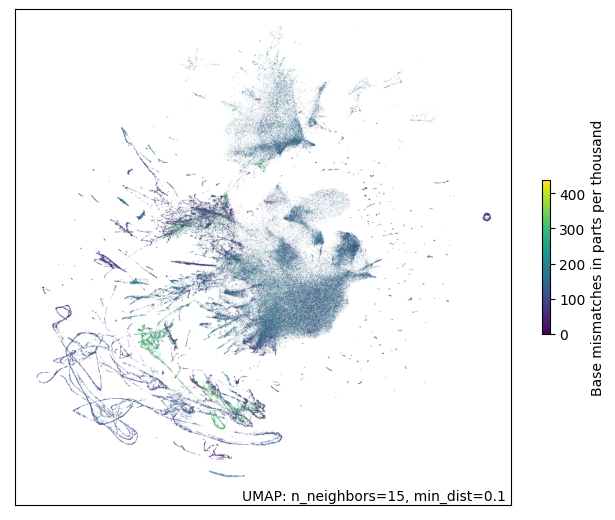

In [19]:
umap_plot_values(windows.milliDiv_, "Base mismatches in parts per thousand")

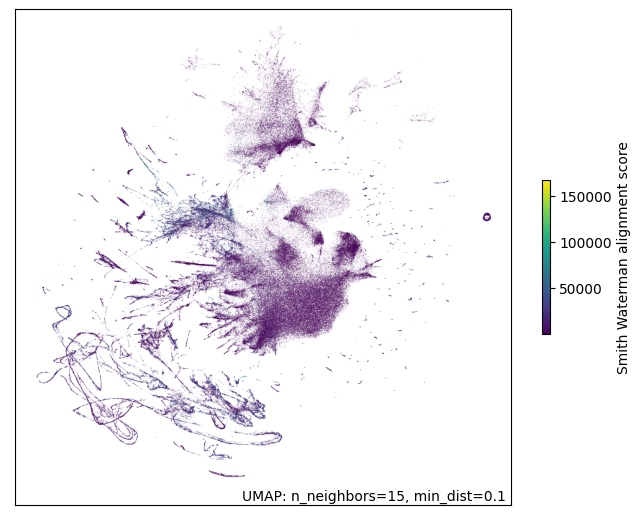

In [20]:
umap_plot_values(windows.swScore_, "Smith Waterman alignment score")